In [1]:
import os, sys
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import numpy as np
import voxelmorph as vxm
import neurite as ne
import torch
import time
from pystrum.pytools.plot import jitter
import matplotlib

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
npz = np.load('/DATA/jakaria_data/CMPUT-617/data/oasis_mini/tutorial_data.npz')
x_train = npz['train']
x_val = npz['validate']

# the 208 volumes are of size 160x192
vol_shape = x_train.shape[1:]
print('train shape:', x_train.shape)
print(vol_shape)

train shape: (208, 192, 160)
(192, 160)


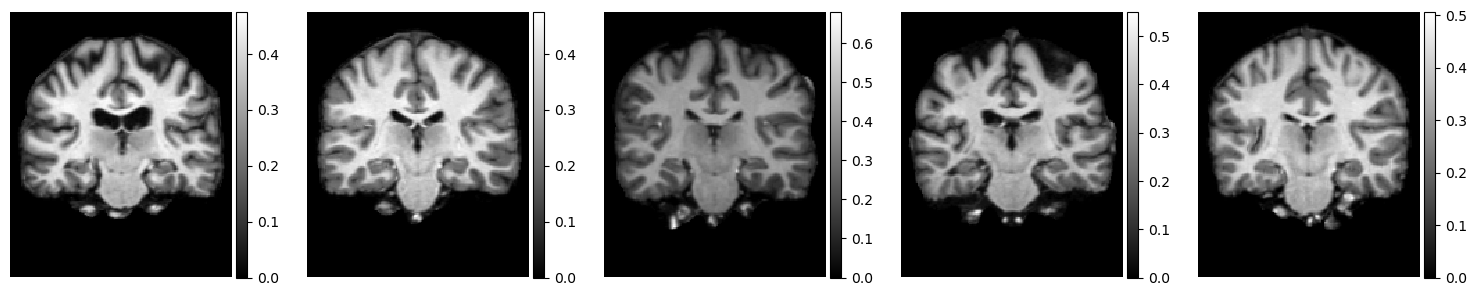

In [4]:
# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [9]:
# configure unet features 
nb_features = [
    [16, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16, 16]  # decoder features
]

# unet
vxm_model = vxm.networks_modified.VxmDense(vol_shape, nb_features)

# losses and loss weights
image_loss_func = vxm.losses.MSE().loss
losses = [image_loss_func]
weights = [1]
losses += [vxm.losses.Grad('l2', loss_mult=2).loss]
weights += [0.01]
print(os.environ['VXM_BACKEND'])

pytorch


In [10]:
vxm_model.to(device)
vxm_model.train()
optimizer=torch.optim.Adam(vxm_model.parameters(),lr=1e-4)

In [11]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

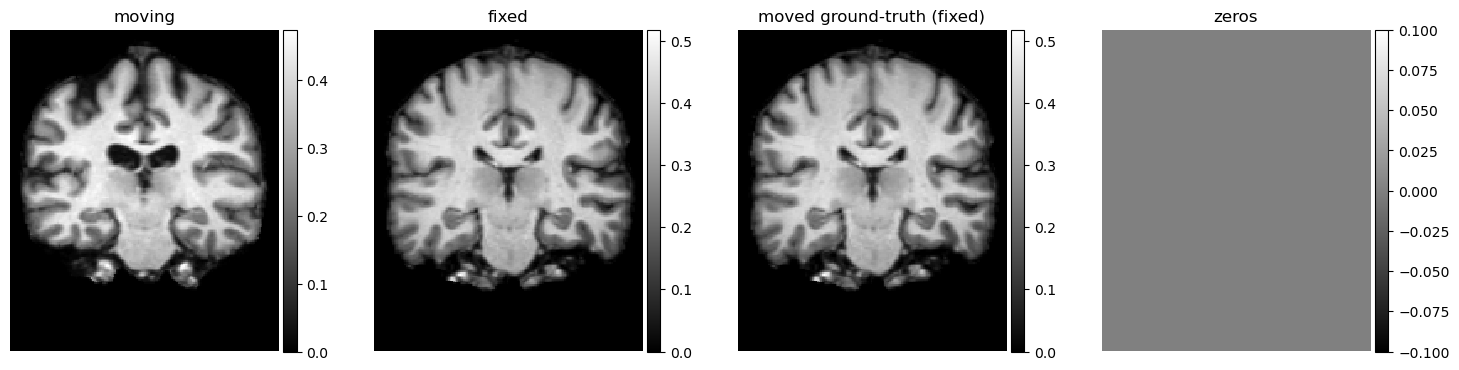

In [12]:
# let's test it
train_generator = vxm_data_generator(x_train, batch_size=8)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [13]:
inputs, y_true = next(train_generator)
for d in y_true:
    print(d.shape)
epochs = 500

(8, 192, 160, 1)
(8, 192, 160, 2)


In [14]:
# training loops
epochs = 500
for epoch in range(0, epochs):

    epoch_loss = []
    epoch_total_loss = []
    epoch_step_time = []

    for step in range(5):

        step_start_time = time.time()

        # generate inputs (and true outputs) and convert them to tensors
        inputs, y_true = next(train_generator)
        inputs = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in inputs]
        y_true = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in y_true]

        # run inputs through the model to produce a warped image and flow field
        y_pred = vxm_model(*inputs)

        # calculate total loss
        loss = 0
        loss_list = []
        for n, loss_function in enumerate(losses):
            curr_loss = loss_function(y_true[n], y_pred[n]) * weights[n]
            loss_list.append(curr_loss.item())
            loss += curr_loss

        epoch_loss.append(loss_list)
        epoch_total_loss.append(loss.item())

        # backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # get compute time
        epoch_step_time.append(time.time() - step_start_time)

    # print epoch info
    epoch_info = 'Epoch %d/%d' % (epoch + 1, 500)
    time_info = '%.4f sec/step' % np.mean(epoch_step_time)
    losses_info = ', '.join(['%.4e' % f for f in np.mean(epoch_loss, axis=0)])
    loss_info = 'loss: %.4e  (%s)' % (np.mean(epoch_total_loss), losses_info)
    print(' - '.join((epoch_info, time_info, loss_info)), flush=True)
vxm_model.save(os.path.join('/DATA/jakaria_data/CMPUT-617/saved_models', '%04d.pt' % epochs))

Epoch 1/500 - 0.3307 sec/step - loss: 6.0134e-03  (6.0134e-03, 3.6402e-08)
Epoch 2/500 - 0.0334 sec/step - loss: 7.4078e-03  (7.4074e-03, 4.1561e-07)
Epoch 3/500 - 0.0309 sec/step - loss: 7.1929e-03  (7.1912e-03, 1.7247e-06)
Epoch 4/500 - 0.0304 sec/step - loss: 6.9675e-03  (6.9622e-03, 5.3737e-06)
Epoch 5/500 - 0.0298 sec/step - loss: 6.7639e-03  (6.7504e-03, 1.3563e-05)
Epoch 6/500 - 0.0323 sec/step - loss: 7.1563e-03  (7.1277e-03, 2.8636e-05)
Epoch 7/500 - 0.0310 sec/step - loss: 6.1252e-03  (6.0696e-03, 5.5510e-05)
Epoch 8/500 - 0.0308 sec/step - loss: 5.6191e-03  (5.5296e-03, 8.9509e-05)
Epoch 9/500 - 0.0311 sec/step - loss: 6.1330e-03  (6.0103e-03, 1.2268e-04)
Epoch 10/500 - 0.0332 sec/step - loss: 6.4732e-03  (6.3136e-03, 1.5960e-04)
Epoch 11/500 - 0.0303 sec/step - loss: 5.9452e-03  (5.7499e-03, 1.9523e-04)
Epoch 12/500 - 0.0306 sec/step - loss: 5.8507e-03  (5.6234e-03, 2.2733e-04)
Epoch 13/500 - 0.0322 sec/step - loss: 5.7131e-03  (5.4720e-03, 2.4111e-04)
Epoch 14/500 - 0.0307

Epoch 109/500 - 0.0284 sec/step - loss: 4.0659e-03  (3.3695e-03, 6.9641e-04)
Epoch 110/500 - 0.0283 sec/step - loss: 3.9781e-03  (3.2732e-03, 7.0487e-04)
Epoch 111/500 - 0.0283 sec/step - loss: 4.0049e-03  (3.2833e-03, 7.2158e-04)
Epoch 112/500 - 0.0284 sec/step - loss: 3.4165e-03  (2.6618e-03, 7.5469e-04)
Epoch 113/500 - 0.0287 sec/step - loss: 3.7376e-03  (3.0402e-03, 6.9744e-04)
Epoch 114/500 - 0.0283 sec/step - loss: 3.6328e-03  (2.8991e-03, 7.3365e-04)
Epoch 115/500 - 0.0282 sec/step - loss: 3.8375e-03  (3.0652e-03, 7.7233e-04)
Epoch 116/500 - 0.0284 sec/step - loss: 3.5676e-03  (2.8109e-03, 7.5673e-04)
Epoch 117/500 - 0.0281 sec/step - loss: 3.8219e-03  (3.0933e-03, 7.2860e-04)
Epoch 118/500 - 0.0284 sec/step - loss: 4.0417e-03  (3.2746e-03, 7.6705e-04)
Epoch 119/500 - 0.0289 sec/step - loss: 3.6346e-03  (2.8532e-03, 7.8140e-04)
Epoch 120/500 - 0.0280 sec/step - loss: 3.8800e-03  (3.1091e-03, 7.7090e-04)
Epoch 121/500 - 0.0277 sec/step - loss: 3.6322e-03  (2.8724e-03, 7.5984e-04)

Epoch 216/500 - 0.0292 sec/step - loss: 3.1386e-03  (2.3230e-03, 8.1561e-04)
Epoch 217/500 - 0.0310 sec/step - loss: 3.5329e-03  (2.7156e-03, 8.1730e-04)
Epoch 218/500 - 0.0316 sec/step - loss: 3.3360e-03  (2.4481e-03, 8.8788e-04)
Epoch 219/500 - 0.0303 sec/step - loss: 3.4908e-03  (2.6142e-03, 8.7658e-04)
Epoch 220/500 - 0.0309 sec/step - loss: 3.4105e-03  (2.5715e-03, 8.3898e-04)
Epoch 221/500 - 0.0305 sec/step - loss: 3.1385e-03  (2.3220e-03, 8.1653e-04)
Epoch 222/500 - 0.0304 sec/step - loss: 3.2606e-03  (2.4283e-03, 8.3228e-04)
Epoch 223/500 - 0.0303 sec/step - loss: 3.1881e-03  (2.3351e-03, 8.5302e-04)
Epoch 224/500 - 0.0299 sec/step - loss: 3.5468e-03  (2.6877e-03, 8.5906e-04)
Epoch 225/500 - 0.0322 sec/step - loss: 3.3299e-03  (2.4972e-03, 8.3276e-04)
Epoch 226/500 - 0.0311 sec/step - loss: 3.3091e-03  (2.4543e-03, 8.5481e-04)
Epoch 227/500 - 0.0294 sec/step - loss: 3.6196e-03  (2.7833e-03, 8.3624e-04)
Epoch 228/500 - 0.0315 sec/step - loss: 3.2853e-03  (2.4541e-03, 8.3115e-04)

Epoch 323/500 - 0.0303 sec/step - loss: 3.1216e-03  (2.2801e-03, 8.4154e-04)
Epoch 324/500 - 0.0294 sec/step - loss: 3.5970e-03  (2.8049e-03, 7.9208e-04)
Epoch 325/500 - 0.0310 sec/step - loss: 3.1484e-03  (2.3197e-03, 8.2863e-04)
Epoch 326/500 - 0.0307 sec/step - loss: 3.1705e-03  (2.3559e-03, 8.1462e-04)
Epoch 327/500 - 0.0310 sec/step - loss: 3.2055e-03  (2.3498e-03, 8.5570e-04)
Epoch 328/500 - 0.0300 sec/step - loss: 3.1912e-03  (2.3601e-03, 8.3117e-04)
Epoch 329/500 - 0.0302 sec/step - loss: 3.3186e-03  (2.4713e-03, 8.4731e-04)
Epoch 330/500 - 0.0310 sec/step - loss: 3.9639e-03  (3.1020e-03, 8.6192e-04)
Epoch 331/500 - 0.0310 sec/step - loss: 3.6057e-03  (2.7510e-03, 8.5469e-04)
Epoch 332/500 - 0.0311 sec/step - loss: 3.1034e-03  (2.2592e-03, 8.4424e-04)
Epoch 333/500 - 0.0306 sec/step - loss: 3.4183e-03  (2.5577e-03, 8.6060e-04)
Epoch 334/500 - 0.0302 sec/step - loss: 3.1201e-03  (2.2645e-03, 8.5561e-04)
Epoch 335/500 - 0.0304 sec/step - loss: 3.0749e-03  (2.2102e-03, 8.6468e-04)

Epoch 430/500 - 0.0285 sec/step - loss: 3.4801e-03  (2.6341e-03, 8.4601e-04)
Epoch 431/500 - 0.0286 sec/step - loss: 3.0398e-03  (2.2180e-03, 8.2179e-04)
Epoch 432/500 - 0.0293 sec/step - loss: 3.5397e-03  (2.6898e-03, 8.4985e-04)
Epoch 433/500 - 0.0281 sec/step - loss: 3.2784e-03  (2.4078e-03, 8.7065e-04)
Epoch 434/500 - 0.0293 sec/step - loss: 3.0813e-03  (2.2176e-03, 8.6367e-04)
Epoch 435/500 - 0.0289 sec/step - loss: 3.0627e-03  (2.2346e-03, 8.2804e-04)
Epoch 436/500 - 0.0282 sec/step - loss: 2.8338e-03  (1.9975e-03, 8.3623e-04)
Epoch 437/500 - 0.0283 sec/step - loss: 3.1580e-03  (2.3080e-03, 8.4997e-04)
Epoch 438/500 - 0.0293 sec/step - loss: 2.9260e-03  (2.1011e-03, 8.2491e-04)
Epoch 439/500 - 0.0294 sec/step - loss: 3.3490e-03  (2.5014e-03, 8.4764e-04)
Epoch 440/500 - 0.0293 sec/step - loss: 3.3385e-03  (2.4962e-03, 8.4233e-04)
Epoch 441/500 - 0.0289 sec/step - loss: 3.4289e-03  (2.5942e-03, 8.3469e-04)
Epoch 442/500 - 0.0280 sec/step - loss: 3.5059e-03  (2.6155e-03, 8.9039e-04)

In [15]:
# create the validation data generator
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

In [16]:
for i in val_input:
    print(i.shape)

(1, 192, 160, 1)
(1, 192, 160, 1)


In [17]:
inputs = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in val_input]

In [22]:
model = vxm.networks_modified.VxmDense.load(os.path.join('/DATA/jakaria_data/CMPUT-617/saved_models', '%04d.pt' % epochs), device)
model.to(device)
print("loaded")

loaded


In [23]:
moved, warp = model(*inputs, registration=True)

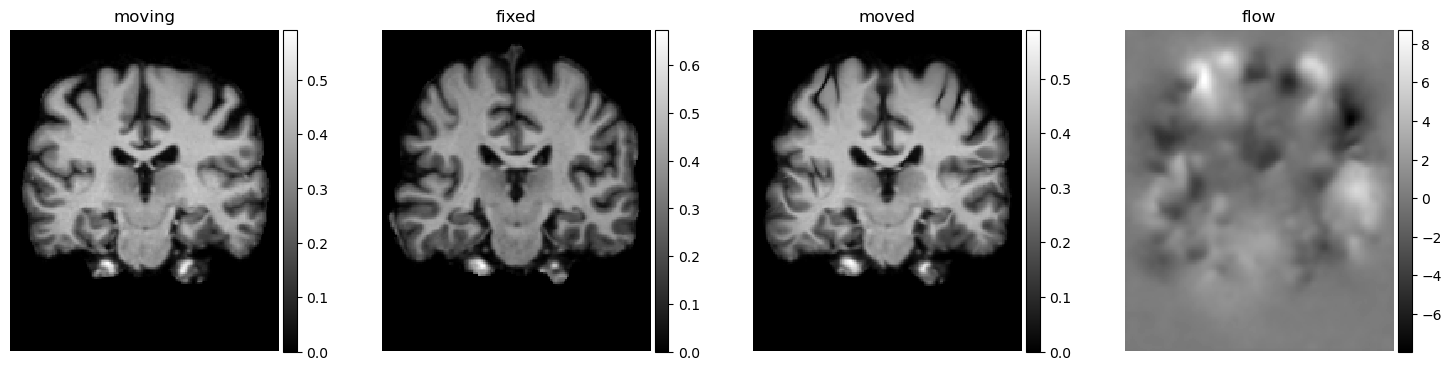

In [24]:
# visualize registration
predicted_output = [moved.detach().cpu().permute(0,2,3,1).numpy(), warp.detach().cpu().permute(0,2,3,1).numpy()]
images = [img[0, :, :, 0] for img in val_input + predicted_output] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

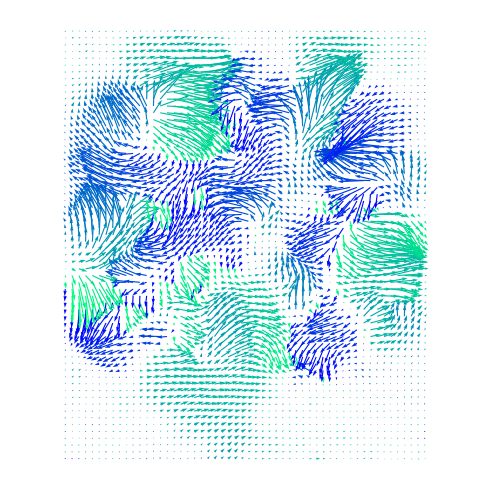

In [25]:
# visualize flow
flow = predicted_output[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

In [26]:
val_volume_1 = np.load('/DATA/jakaria_data/CMPUT-617/data/oasis_mini/subj1.npz')['vol']
seg_volume_1 = np.load('/DATA/jakaria_data/CMPUT-617/data/oasis_mini/subj1.npz')['seg']
val_volume_2 = np.load('/DATA/jakaria_data/CMPUT-617/data/oasis_mini/subj2.npz')['vol']
seg_volume_2 = np.load('/DATA/jakaria_data/CMPUT-617/data/oasis_mini/subj2.npz')['seg']

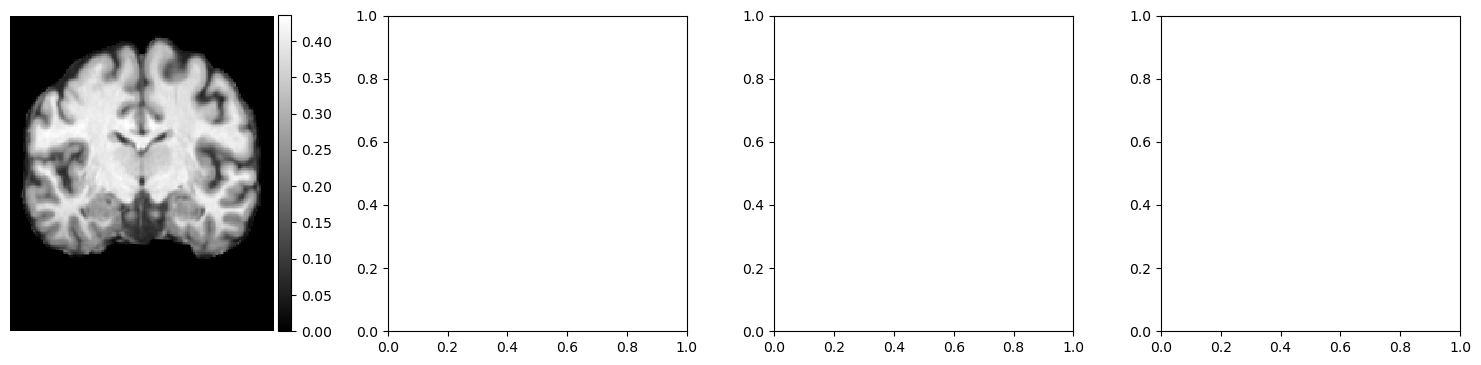

In [27]:
vol_shape = (160, 192, 224)
mid_slices_fixed = np.take(val_volume_1, vol_shape[2]//2, axis=2)
mid_slices_fixed = np.rot90(mid_slices_fixed, -1)
ne.plot.slices(mid_slices_fixed, cmaps=['gray'], do_colorbars=True, grid=[1,4]);

In [28]:
new_volume_1 = []
for i in range(100, 124):
    fixed = np.take(val_volume_1, i, axis=2)
    fixed = np.rot90(fixed, -1)
    new_volume_1.append(fixed)

In [29]:
new_volume_2 = []
for i in range(100, 124):
    fixed = np.take(val_volume_2, i, axis=2)
    fixed = np.rot90(fixed, -1)
    new_volume_2.append(fixed)

In [30]:
new_volume_1 = np.array(new_volume_1)
print(new_volume_1.shape)
new_volume_2 = np.array(new_volume_2)
print(new_volume_1.shape)

(24, 192, 160)
(24, 192, 160)


In [31]:
new_seg_1 = []
for i in range(100, 124):
    fixed = np.take(seg_volume_1, i, axis=2)
    #fixed = np.rot90(fixed, -1)
    new_seg_1.append(fixed)

In [32]:
new_seg_2 = []
for i in range(100, 124):
    fixed = np.take(seg_volume_2, i, axis=2)
    #fixed = np.rot90(fixed, -1)
    new_seg_2.append(fixed)

In [33]:
new_seg_1 = np.array(new_seg_1)
print(new_seg_1.shape)
new_seg_2 = np.array(new_seg_2)
print(new_seg_2.shape)

(24, 160, 192)
(24, 160, 192)


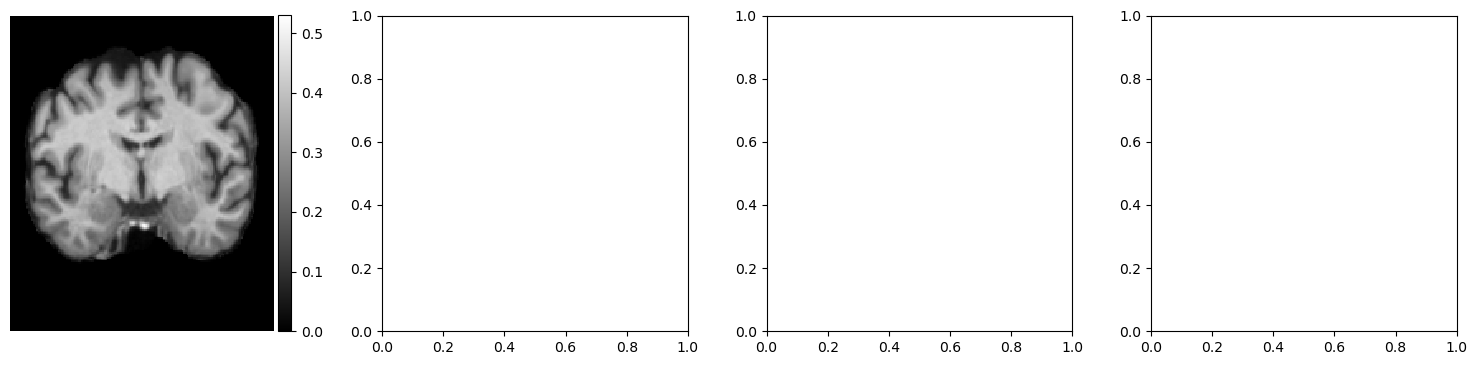

In [34]:
ne.plot.slices(new_volume_1[20], cmaps=['gray'], do_colorbars=True, grid=[1,4]);

In [35]:
# Data generator with segment masks
def vxm_data_generator_w_segment(x_data, segmentations, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        seg1 = segmentations[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        seg2 = segmentations[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        seg = [seg1, seg2]
        
        yield (inputs, outputs, seg)

In [36]:
moving = new_volume_1[20]
fixed = new_volume_2[20]
val_input = [moving[np.newaxis, ..., np.newaxis], fixed[np.newaxis, ..., np.newaxis]]

In [37]:
inputs = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in val_input]

In [38]:
moved, warp = model(*inputs, registration=True)

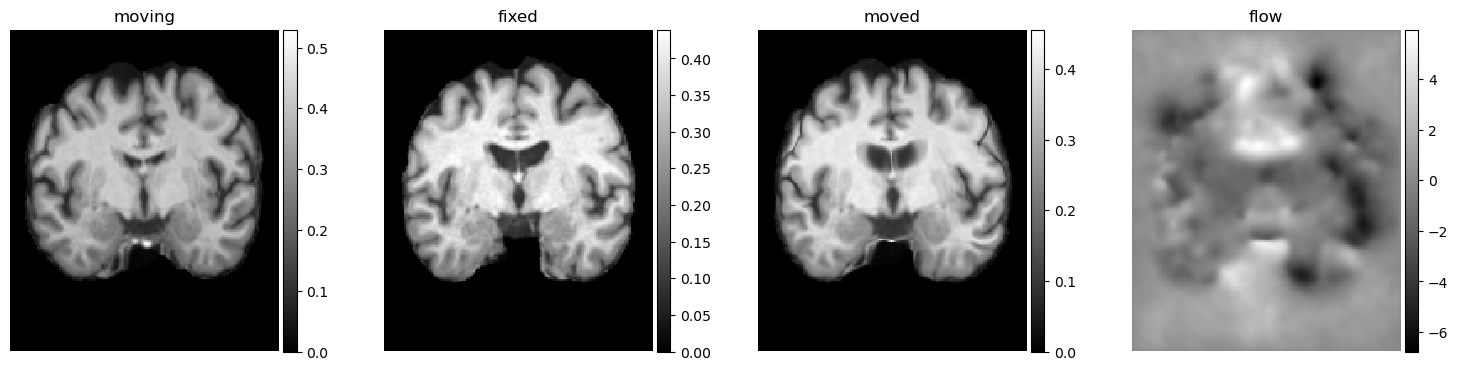

In [39]:
# visualize registration
predicted_output = [moved.detach().cpu().permute(0,2,3,1).numpy(), warp.detach().cpu().permute(0,2,3,1).numpy()]
images = [img[0, :, :, 0] for img in val_input + predicted_output] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

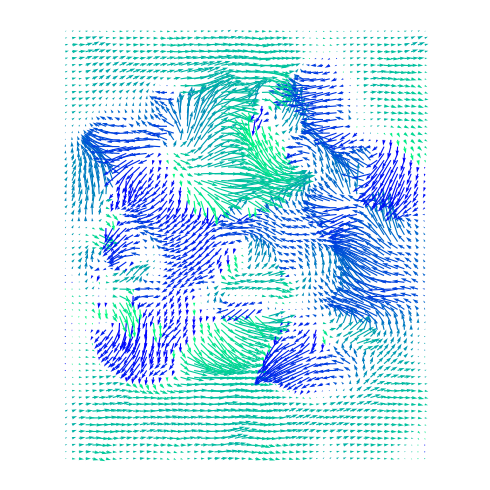

In [40]:
# visualize flow
flow = predicted_output[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

In [41]:
from pystrum.pytools.plot import jitter
import matplotlib

[ccmap, scrambled_cmap] = jitter(255, nargout=2)
scrambled_cmap[0, :] = np.array([0, 0, 0, 1])
ccmap = matplotlib.colors.ListedColormap(scrambled_cmap)

In [42]:
# create the validation data generator
#val_generator_seg = vxm_data_generator_w_segment(new_volume_1, new_seg_1, batch_size = 1)
#val_input, _, seg = next(val_generator_seg)
moving = new_volume_1[20]
fixed = new_volume_2[20]
val_input = [moving[np.newaxis, ..., np.newaxis], fixed[np.newaxis, ..., np.newaxis]]
moving_seg = new_seg_1[20]
fixed_seg = new_seg_2[20]
val_seg = [moving_seg[np.newaxis, ..., np.newaxis], fixed_seg[np.newaxis, ..., np.newaxis]]

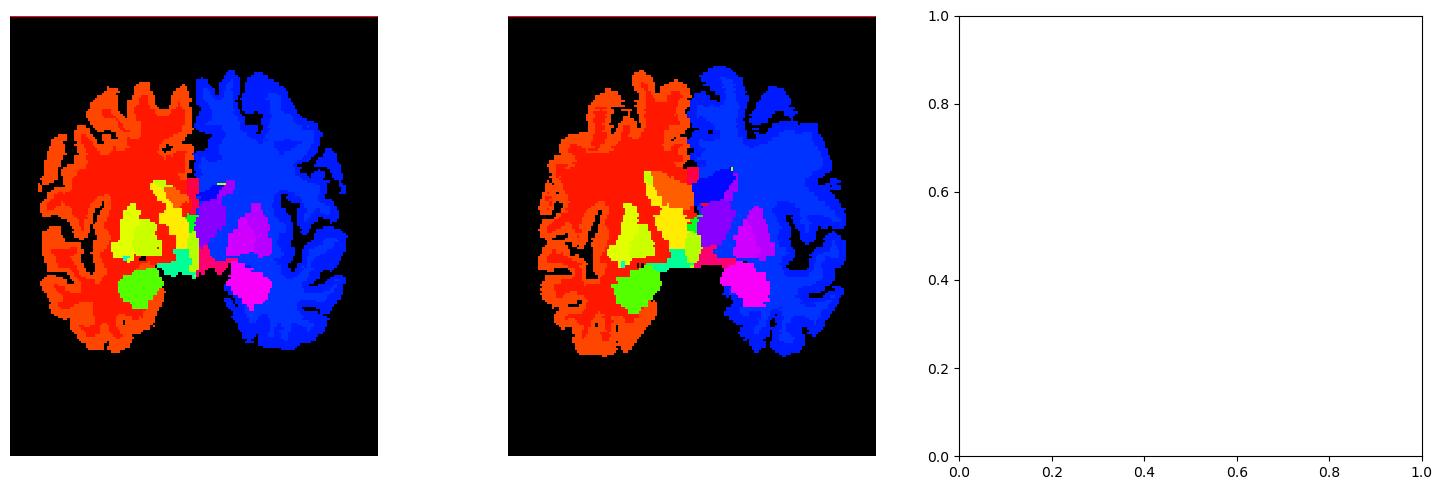

(192, 160)

In [43]:
val_seg = [val_seg[0][0,:,:,0], val_seg[1][0,:,:,0]]
val_seg[0] = np.rot90(val_seg[0], -1)
val_seg[1] = np.rot90(val_seg[1], -1)
slices = val_seg
for si, slc  in enumerate(slices):
    slices[si][0] = 255
ne.plot.slices(slices, cmaps = [ccmap], grid=[1,3]);
slices[1].shape

In [44]:
slices[0].shape

(192, 160)

In [45]:
predicted_flow = warp
predicted_flow.shape

torch.Size([1, 2, 192, 160])

In [46]:
seg_input_val = val_seg[0][np.newaxis, ..., np.newaxis]
seg_input_val = seg_input_val.copy()
print(seg_input_val.shape)

(1, 192, 160, 1)


In [47]:
transform = vxm.layers.SpatialTransformer((192, 160))

In [48]:
warped_seg_0 = transform(torch.from_numpy(seg_input_val).float().permute(0, 3, 1, 2), predicted_flow.detach().cpu())

In [49]:
warped_seg_0.shape

torch.Size([1, 1, 192, 160])

In [50]:
val_seg[1].shape

(192, 160)

In [51]:
warped_seg_0 = warped_seg_0.detach().cpu().permute(0,2,3,1).numpy()

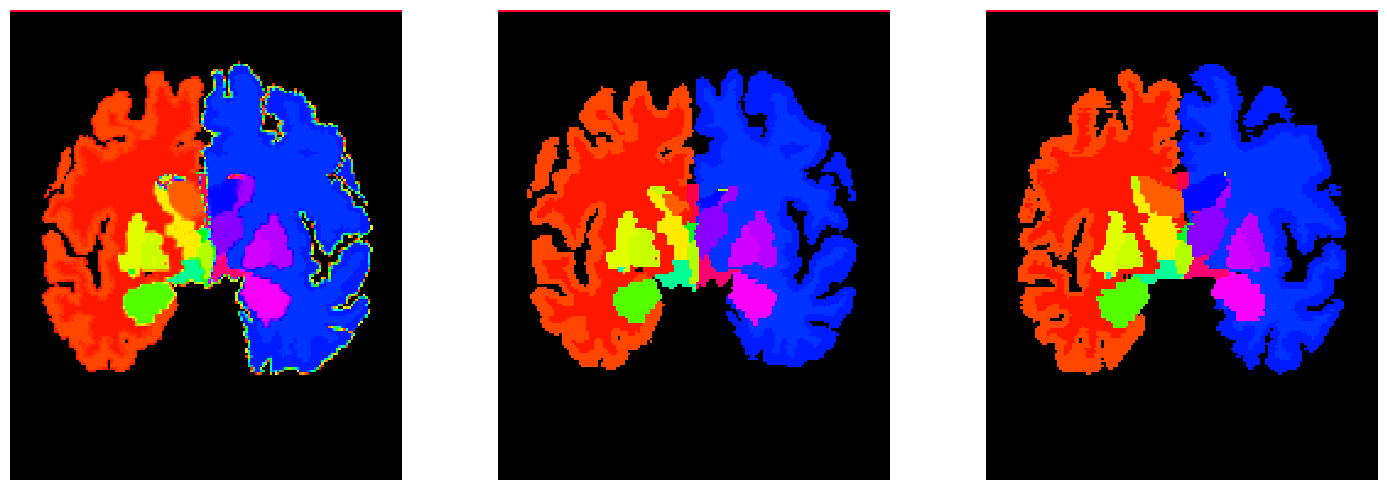

(192, 160)

In [52]:
val_seg = [warped_seg_0[0,:,:,0], val_seg[0], val_seg[1]]
slices = val_seg
for si, slc  in enumerate(slices):
    slices[si][0] = 255
ne.plot.slices(slices, cmaps = [ccmap], grid=[1,3]);
slices[1].shape

In [53]:
slices_0 = np.rint(slices[0])
slices_0 = slices_0.astype(int)

In [54]:
mask = np.isin(slices_0, slices[1])
slices_0[~mask] = 0

In [55]:
np.unique(slices_0)

array([  0,   2,   3,   4,  10,  11,  12,  13,  14,  18,  24,  28,  30,
        41,  42,  43,  49,  50,  51,  52,  54,  60,  77, 253, 255])

In [56]:
slices[0] = slices_0

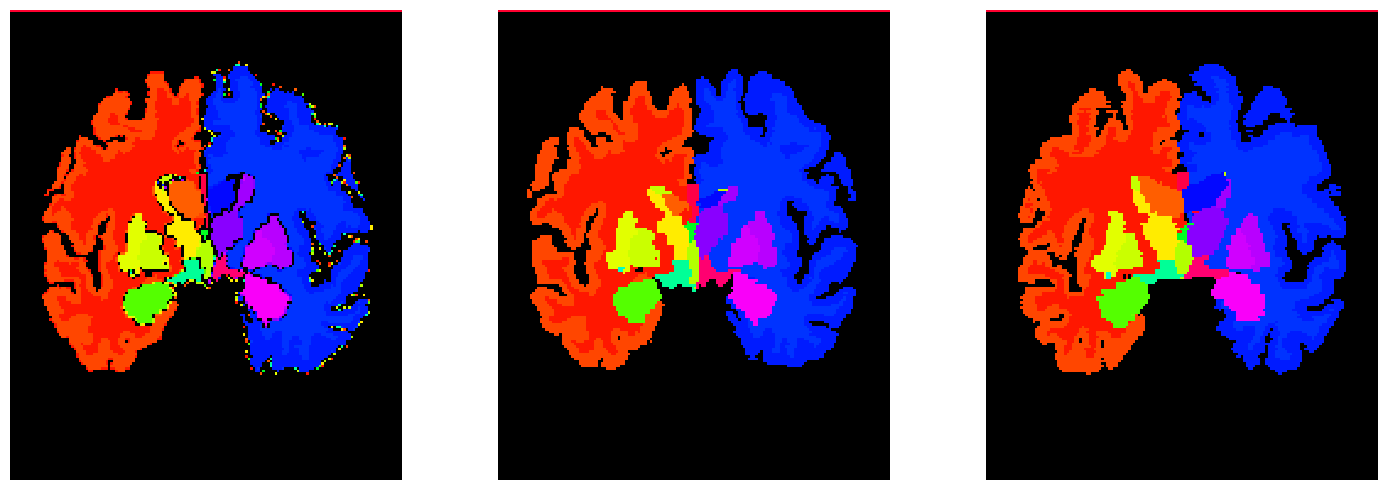

(192, 160)

In [57]:
for si, slc  in enumerate(slices):
    slices[si][0] = 255
ne.plot.slices(slices, cmaps = [ccmap], grid=[1,3]);
slices[1].shape

In [60]:
def dice_coefficient(mask1, mask2):
    intersection = np.sum(np.logical_and(mask1, mask2))
    union = np.sum(np.logical_or(mask1, mask2))
    dice_score = 2 * intersection / (union + 1e-6)  # add epsilon to avoid division by zero
    return dice_score

# Calculate the average Dice score for the 31 segmentation masks
dice_scores = []
for i in range(31):
    # Create a binary mask by thresholding each array at the value of i
    mask1 = (slices[1] == i).astype(int)
    mask2 = (slices[2] == i).astype(int)
    dice_score = dice_coefficient(mask1, mask2)
    dice_scores.append(dice_score)

avg_dice_score = np.mean(dice_scores)
print("Average Dice score:", avg_dice_score)

Average Dice score: 0.42718465887248747
